In [25]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time

In [41]:
torch.manual_seed(42)
loss_evolution = []

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def func(x, l):
    w = 2*torch.pi/(l)
    f = torch.sin(x*w)
    return f

def loss_fn(f, df2, fx0, df, f_boundry, df_boundry, lengh, t):
    w = 2*torch.pi/(lengh)
    interior = df2 + (w**2)*f
    boundry =  fx0 - f_boundry
    dboundry = df - df_boundry
    loss_value = (torch.mean((interior)**2) + 20*torch.mean(boundry**2) + 20*torch.mean(dboundry**2))

    return loss_value




def PINN(fcnn, domain, lengh, batch_size, learning_rate, epochs, itr_show):
    model = fcnn
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    t = torch.linspace(domain[0], domain[1], batch_size)
    t = t.view(t.shape[0], 1)

    f_boundry = torch.tensor([[0.0]])
    f_boundry = f_boundry.view(f_boundry.shape[0], 1)
    df_boundry = torch.tensor([[2*torch.pi]])
    df_boundry = df_boundry.view(df_boundry.shape[0], 1)
    
    t1 = time.time()

    for epoch in range(epochs):
        t.requires_grad = True
        f = model(t)
        df = grad(f,t)[0]
        df2 = grad(df,t)[0]


        loss = loss_fn(f, df2, f[0], df[0], f_boundry, df_boundry,lengh, t)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_evolution.append(float(loss))

        if (epoch) % itr_show == 0:
            print(f'iteration {epoch}/{epochs}, loss = {loss}')

            t = torch.linspace(domain[0], domain[1],10000)
            t = t.view(t.shape[0], 1)
            predicted = model(t)
            analytic_cal = func(t, lengh)

            fig, ax = plt.subplots()
            ax.plot(t, analytic_cal, "r-",label='analytic solution')
            ax.plot(t.detach().numpy(), predicted.detach().numpy(), "b--", label='PINN final solution')
            ax.set(title='$d^2{F}/dt^{2} + ω F$', xlabel="t", ylabel="$F_t$")
            ax.legend()
            plt.show()
    t2 = time.time()
    print("Time:", t2- t1)
    return loss_evolution

# Classical Neural Network

# $$\frac{d^2f}{dt^2} + \omega \cdot f
$$
# $$f(t=0) = 0$$
# $$f(t=1/4) = 1$$
# $$
Solution = ASin[\omega \cdot t]$$
# $$ A = 1  \hspace{10pt}  \omega = 2pi $$

In [47]:
torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)
        return out
input_size, hidden_size, output_size = 1, 16, 1
NN = NeuralNet(input_size, hidden_size, output_size)

iteration 0/501, loss = 1115.3662109375


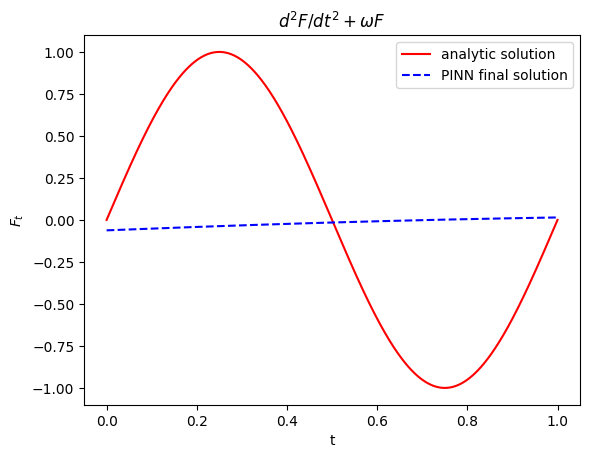

iteration 100/501, loss = 69.5753173828125


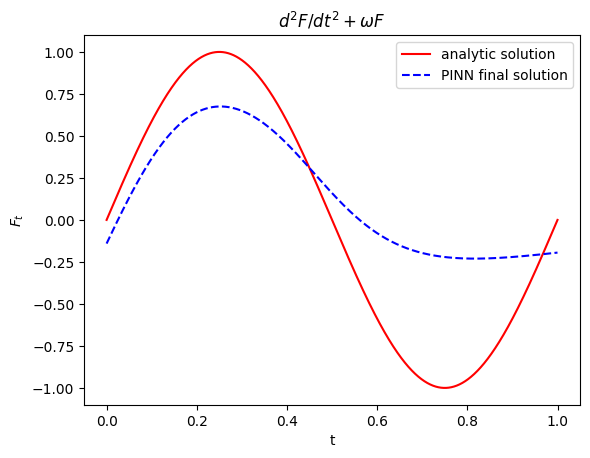

iteration 200/501, loss = 0.3514745831489563


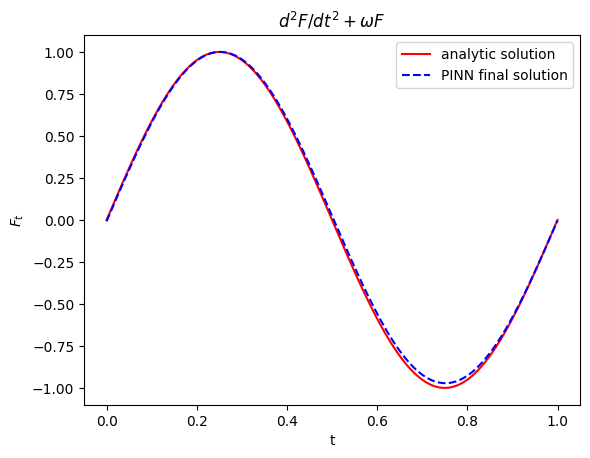

iteration 300/501, loss = 0.3537420928478241


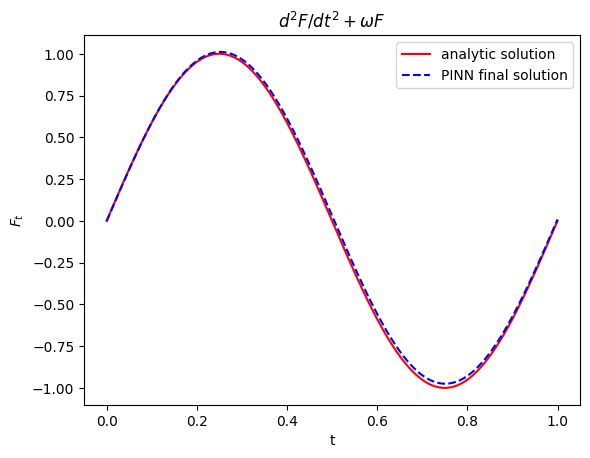

iteration 400/501, loss = 0.014607755467295647


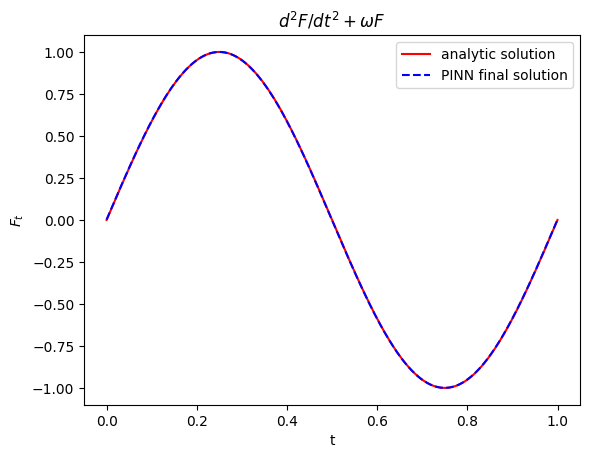

iteration 500/501, loss = 0.009235061705112457


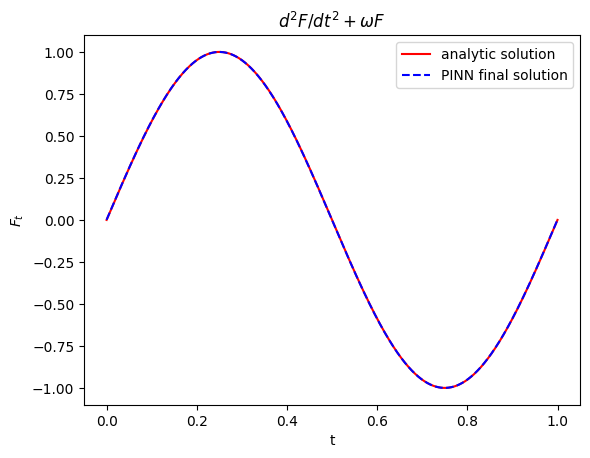

Time: 13.209168195724487


In [48]:
loss1 = []
lengh = 1.0
domain = (0, lengh)
batch_size = 50
learning_rate = 0.025
epochs = 501
loss1 = PINN(NN, domain, lengh, batch_size, learning_rate, epochs, 100)

# Hybrid Neural Network

In [12]:
torch.manual_seed(42)
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1): 
        qml.CNOT(wires=[i, i + 1])
        
@qml.qnode(dev)
def quantum_net1(q_input_features, q_weights_flat,q_depth):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    RY_layer(q_input_features[0:3])
    RY_layer(q_weights[0])
    entangling_layer(3)
    RY_layer(q_input_features[3:6])
    RY_layer(q_weights[1])
    
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(0, n_qubits)]

    return tuple(exp_vals)

class HQNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, q_depth,out_put):
        super().__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size,6)
        self.l3 = nn.Linear(n_qubits,1)
        self.tanh = nn.Tanh()
        self.q_params = nn.Parameter(0.2*torch.randn(q_depth * n_qubits))
        self.depth = q_depth
    
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.l2(out)
        q_out = torch.Tensor(0, 3)
        for elem in out:
            q_out_elem = torch.hstack(tuple(quantum_net1(elem, self.q_params,self.depth))).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        out = self.l3(q_out)
        return out        

input_size, hidden_size, n_qubits, q_depth, out_put = 1, 16, 3, 2, 1
HNN = HQNeuralNet(input_size, hidden_size, n_qubits, q_depth, out_put)

iteration 0/201, loss = 2420.413330078125


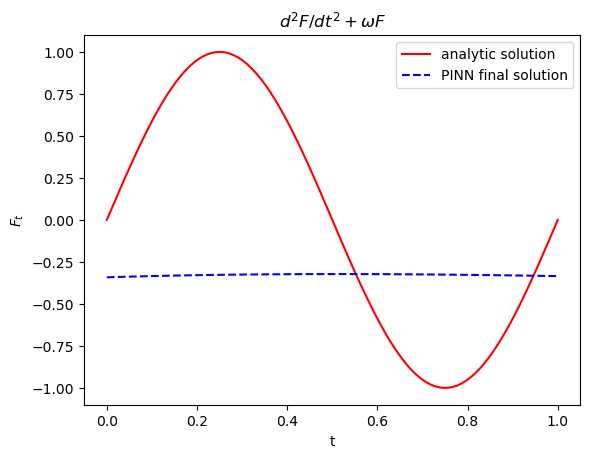

iteration 20/201, loss = 755.3309326171875


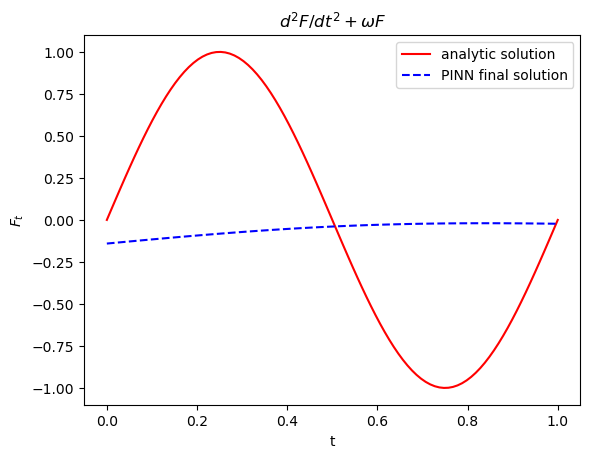

iteration 40/201, loss = 102.64163208007812


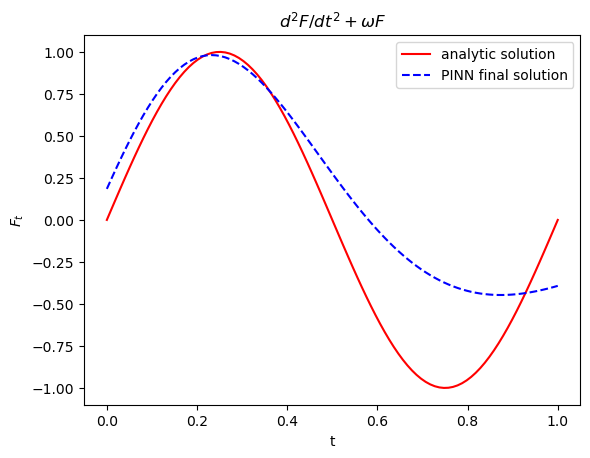

iteration 60/201, loss = 21.703271865844727


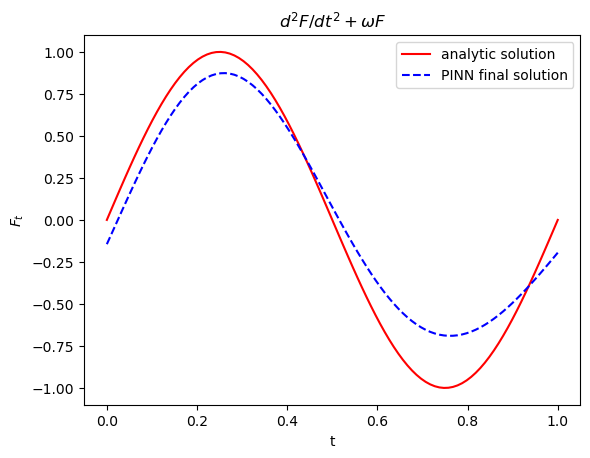

iteration 80/201, loss = 5.793615341186523


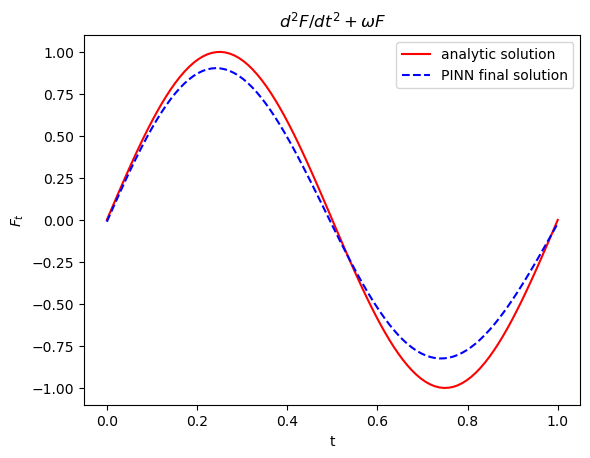

iteration 100/201, loss = 0.4656674265861511


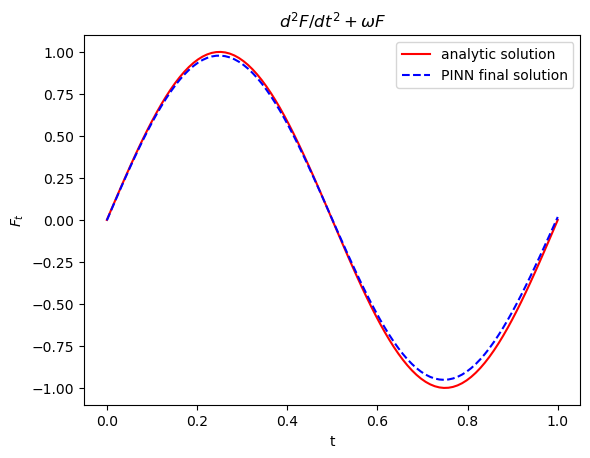

iteration 120/201, loss = 0.03984541818499565


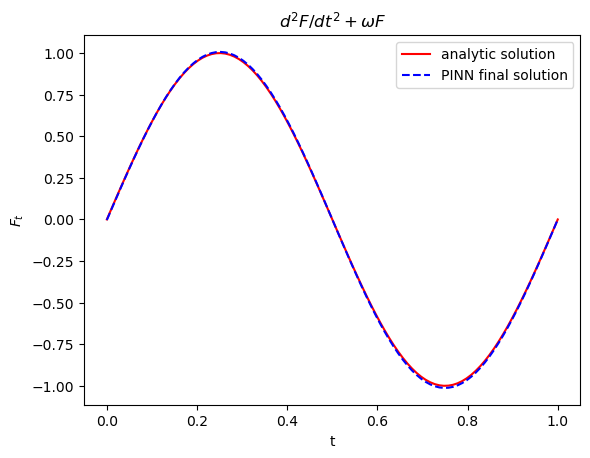

iteration 140/201, loss = 0.026899363845586777


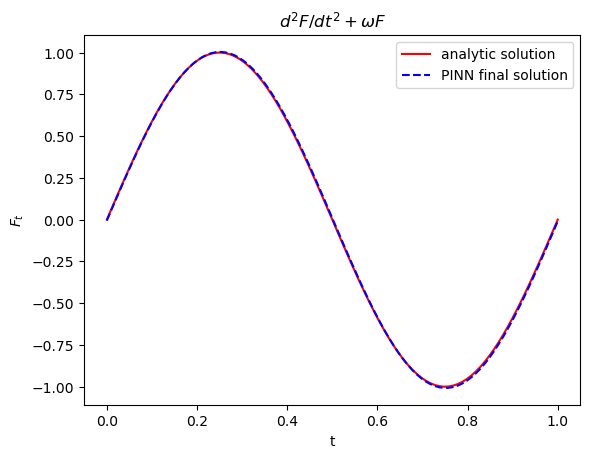

iteration 160/201, loss = 0.014414606615900993


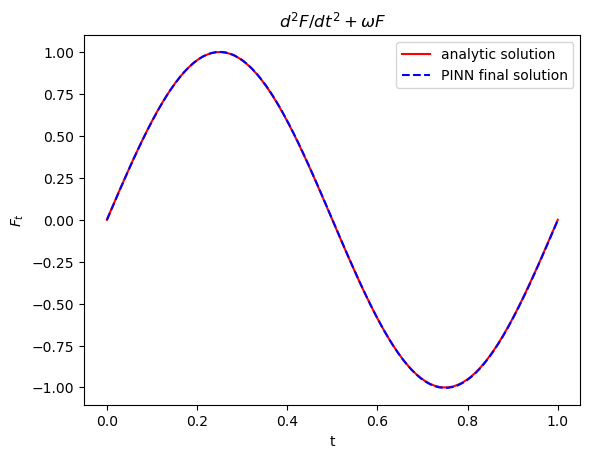

iteration 180/201, loss = 0.012783032841980457


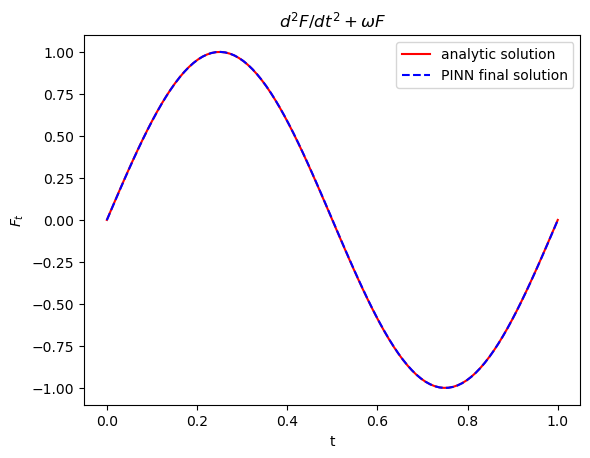

iteration 200/201, loss = 0.012157075107097626


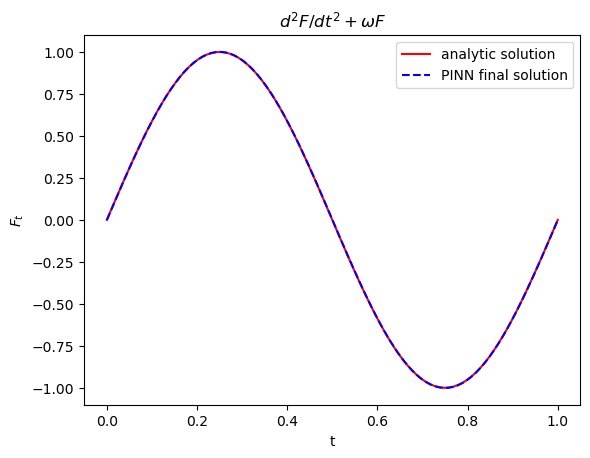

Time: 951.9138495922089


In [13]:
lengh = 1.0
domain = (0, lengh)
batch_size = 50
learning_rate = 0.05
epochs = 201
loss1 = PINN(HNN, domain, lengh, batch_size, learning_rate, epochs, 20)